# 분류 - mnist

## 데이터 다운받기

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X,y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


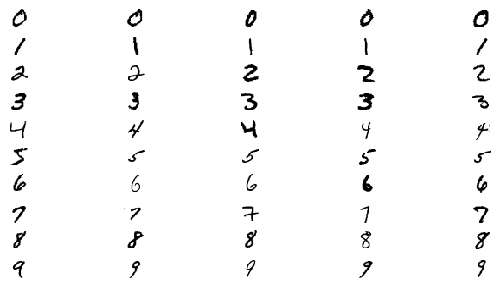

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(10,5))
for i in range(10):
    idx = np.where(y==str(i))[0][:5] # 해당 숫자에 해당하는 index 위치 반환
    for th, j in enumerate(idx):
        plt.subplot(10,5,(th+1)+(i*5))
        digit = X[j].reshape(28,28)
        plt.imshow(digit, cmap="binary")
        plt.axis("off")

In [38]:
import numpy as np

In [41]:
y = y.astype(np.uint8)

In [42]:
# 앞쪽 60,000개 이미지와 뒤쪽 60,000개 이미지로 이미 나누어져 있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

In [43]:
# 숫자 5만 식별하는 이진분류기
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [49]:
# SGD Classifier : 확률적 경사하강법(한 epoch 뒤에 데이터를 다시 무작위로 섞기 때문)
# 한개 한개 샘플을 독립적으로 처리
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

predicted = sgd_clf.predict(X_test)

## 분류 성능측정
- 정확도 : (맞은 개수)/(전체 개수)
    - 불균형한 데이터셋의 경우 적절한 성능 측정 지표가 아님
- 오차행렬
    - 행: 실제(음, 양), 열 : 예측(음,양)
    - TN(맞음, 음성예측), FP(틀림, 양성예측)
    - FN(틀림, 음성예측), TP(맞음, 양성예측)
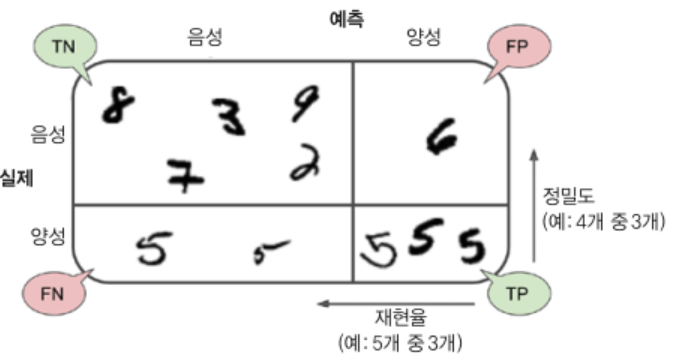
- 정밀도 : (양성이라고 예측한 것 중 양성인 개수)/(양성이라고 예측한 것의 개수)
    - 스팸메일
- 재현율 : (양성 예측&실제 양성)/(실제 양성인 것의 개수)
    - 의료 질병

- F1점수 : 정밀도와 재현율의 조화 평균
    - 정밀도와 재현율이 비슷할 수록 F1 점수가 높아짐.
- **정밀도/재현율 트레이드오프** : 정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어듦
    - 임계값을 높이면 양성이라고 예측하는 개수가 줄어듦. -> 정밀도가 커지고, 재현율이 작아짐
    - 임계값을 낮추면 양성이라고 예측하는 개수가 많아짐. -> 정밀도가 줄어들고, 재현율이 커짐.
    - 임계값을 높이더라도 정밀도가 줄어드는 현상이 가끔 발생하기 때문에 정밀도가 재현율보다 울퉁불퉁
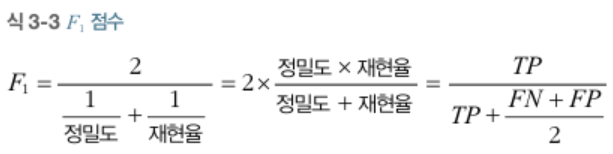

과제에 따라 적절한 정밀도/재현율을 고르는 것이 필요

In [60]:
# 교차 검증 구현(cross-val-score과 거의 같은 기능 함수)
from sklearn.model_selection import StratifiedKFold
# 클래스별 비율이 유지되도록 폴드를 만들고 계층적 샘플링을 수행

from sklearn.base import clone
# 데이터를 제외하고 모델만 복사(fit 하기 전에 모델 선언하는 곳까지)하는 함수

skfolds = StratifiedKFold(n_splits = 3, random_state=42)
# test set은 맨 마지막에 완성된 모델에 대한 성능 측정을 위해서만 쓰여져야 하기 때문에 train set으로

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) # 모델 복사
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred)) # 정확도로 성능 평가

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [54]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [55]:
# 모든 데이터를 5가 아닌 것으로 예측하는 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self # 아무 일도 하지 않음
    def predict(self, X):
        return np.zeros(X.shape[0], dtype=bool) 

In [56]:
never5Classifier = Never5Classifier()
cross_val_score(never5Classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

In [58]:
# cross_val_score과 비슷하지만 여기선 결과로 예측값을 반환(모든 데이터에 대해 순서에 맞춰서)
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix # 오차행렬

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [65]:
# 정밀도, 재현율
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # (3530)/(687+3530) # 정밀도
print(recall_score(y_train_5, y_train_pred)) # (3530)/(3530+1891) # 재현율

0.8370879772350012
0.6511713705958311


In [70]:
# 정밀도와 재현율 트레이드 오프
y_scores = sgd_clf.decision_function(X_train) # 각 데이터의 점수 확인
y_scores
threshold = int(input()) # 임계값
y_some_digit_pred = (y_scores>threshold) # 임계값을 기준으로 예측

8000


In [71]:
# cross_val_predict를 통하여 모든 데이터의 점수 확인
# 한번에 훈련 -> 한번에 예측하게 되면 예측에 대한 신뢰도가 떨어지기 때문에 cross_val_predict를 통하여
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

# precision_recall_curve(실제 레이블, 각 데이터 점수)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [76]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # recalls, precisions 모두 맨 마지막 값(그냥 1로 디폴트)은 제외해주어야 함
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.xlabel("임계값")
    plt.legend()
    plt.grid()

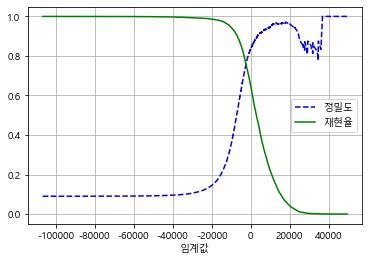

In [81]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

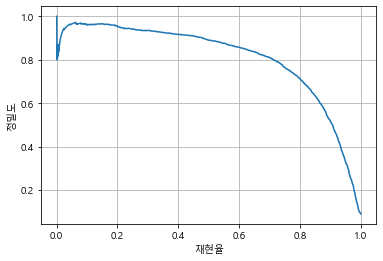

In [90]:
import seaborn as sns
# 재현율에대한 정밀도를 그리는 것이 좋음! (정밀도가 올라갔다 내려갔다 하는 구간이 있기 때문에)
sns.lineplot(x=recalls[:-1], y=precisions[:-1])
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.grid()
# 재현율 80% 근처에서 정밀도가 급격하게 줄어듦 -> 하강점 직전을 선택하는 것도 좋은 방법
# 이러한 선택은 프로젝트에 따라 달라짐

In [94]:
# 정밀도 90%를 달성하는 것이 목표
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
threshold_90_precision # 정밀도 90%를 최초로 달성하게 하는 임계값

# 정밀도 90%를 달성하게 하는 임계값으로 예측
y_train_pred_90 = (y_scores>=threshold_90_precision)

# 정밀도와 재현율 확인
print("재현율", precision_score(y_train_5, y_train_pred_90))
print("정밀도", recall_score(y_train_5, y_train_pred_90))

재현율 0.9000345901072293
정밀도 0.4799852425751706


- ROC 곡선 : 거짓양성비율에 대한 진짜양성 비율, 좋은 분류기일수록 아래 면적이 1(직사각형)
    - 거짓양성비율 : 1 - 특이도
        - (양성으로 잘못 예측)/(전체 음성개수)
        - FP/(TN+FP)
    - 진짜양성비율 : 재현율
        - TP/(FN+TP)
    - 특이도 : (음성으로 잘 예측)/(전체 음성 개수)
        - TN/(TN+FP)

In [95]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

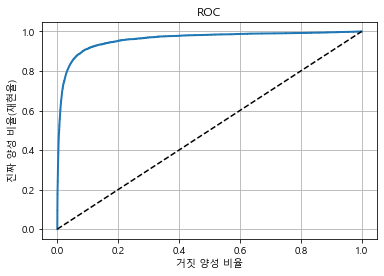

In [96]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--") # 대각점선 # 완전한 랜덤 분류기
    plt.xlabel("거짓 양성 비율")
    plt.ylabel("진짜 양성 비율(재현율)")
    plt.grid()
    plt.title("ROC")
    
plot_roc_curve(fpr,tpr)
plt.show()

In [97]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

양성 클래스가 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용
    - 양성 클래스가 드물면 AUC점수가 잘나옴
    - y축이 재현율이기 때문에 거짓 음성에 신경씀 -> 거짓 양성이 더 중요할 때는 PR 곡선

In [100]:
# randomforest를 이용한 ROC, AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
# 예측라벨이 아닌 예측 확률 반환, dicision_function()이 아닌 predict_proba()
# (음성일 확률, 양성일 확률) -> 2차원 배열 반환
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")

In [102]:
y_scores_forest = y_probas_forest[:, 1] # 양성클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

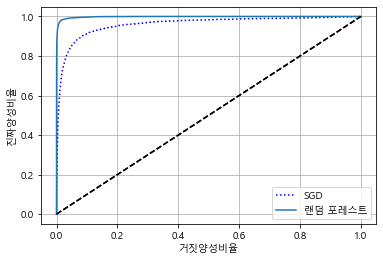

In [110]:
# SGD와 랜덤 포레스트 ROC 곡선 비교
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label = "랜덤 포레스트")
plt.legend(loc = "lower right")
plt.grid()
plt.xlabel("거짓양성비율")
plt.ylabel("진짜양성비율")
plt.plot([[0,0],[1,1]], "k--")
plt. show()

# 랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가깝기 때문에 랜덤 포레스트가 더 좋음

In [111]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 다중분류
- 이진 분류기(SVM/logistic Regression 등은 이진분류만 가능) 를 이용하여 다중 분류 시스템을 만드는 방법
    - OvA : 특정 클래스일 확률을 구하여 가장 높은 클래스를 선택 (others)
    - OvO : 각 숫자의 두개 조합마다 이진 분류기를 학습, -> 가장 많이 분류된 클래스 선택 (SVM)
         - 훈련시에 두 클래스에 해당하는 샘플만 필요
- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 자동으로 OvR 또는 OvO 실행

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # 다중분류이기 때문에 y_train_5가 아닌 y_train 사용
svm_clf.predict(X_train)

In [ ]:
some_digit_scores = svm_clf.decision_function(X_train)
some_digit_scores

In [ ]:
label_idx = np.argmax(some_digit_scores) # 예측 label의 index값, 여기서는 label 값과도 같음
svm_clf.classes_[label_idx]

## 에러분석
- 에러 종류를 살펴봄으로써 모델의 성능을 향상시킬 수 있음

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums

## 다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

## 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_te

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")